This notebook contains all the code to reproduce the figures related to RIPE Atlas data

## Import all modules and set global variables

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
import json
import pandas as pd
import ipaddress
import sys
from tqdm import tqdm
import pyasn
import os, glob
from matplotlib import colors as pltColors
import geopandas
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
import copy
import collections
import sqlite3
import haversine as hs
from matplotlib.patches import Patch
from scipy import stats
import statistics
import shutil

# Latex needs to be available in order to build the exact plots we used in the paper
plt.rc('text', usetex=True if shutil.which('latex') else False)

# We are using the tab10 colormap
cols = plt.get_cmap("tab10").colors

# fe = font_manager.FontEntry(fname="/Users/Library/Fonts/cmu.sans-serif-medium.ttf", name="CMU Sans Serif")
# font_manager.fontManager.ttflist.insert(0,fe)

# Create the figure output dir
os.makedirs("Figs", exist_ok=True)

data_path_var = "DATA_PATH"

# Use the os.environ dictionary to access the value
data_path_val = os.environ.get(data_path_var)

base_folder = f"{data_path_val}/atlas/ripe_atlas_repr"
print(base_folder)
asndb = pyasn.pyasn(f'{base_folder}/common/ipasn_latest.dat')
rcParams["font.family"] = "CMU Sans Serif"
rcParams["font.size"] = 10

None/atlas/ripe_atlas_repr


OSError: Could not open the file.

## Filter RIPE Atlas traceroute data

In [6]:
set1_ripe_atlas_probe_dict = {}
set1_ripe_atlas_probe_dict_not_starlink = {}
starlink_prb = []
ip_to_asn = {}
pop_map = {}
ixp_map = {}
gs_map = {}
# The newer + older measurements
first_hop_filtered_json_list = []

# Segregating the older and newer measurements as we could not pinpoint some POP locations in Australia and New Zealand for the newer measurements
# This is used when we plot the correlation of the distance from Dishy to GS with observed median RTT to GS
# The newer measurements list
first_hop_filtered_json_list_new_msm = []
# The older measurements list
first_hop_filtered_json_list_old_msm = []

timestamp_ids = set()
new_probes = list()


all_prb_details_file = open(f"{base_folder}/ripe_prb_details/all_final_prb_details_ripe.json", "r")
all_prb_details_json = json.load(all_prb_details_file)
    

measurements_path = f'{base_folder}/traceroute/'


first_hop_filtered_dict = {
            'msm_name':"",
            'prb_id' :"",
            'starlink_net_hops' :[],
            'src_addr': "",
            'dst_addr':"",
            'country_code':"",
            'from_ip': "",
            'gs_hop_ip': "",
            'gs_hop': 0,
            'gs_rtts': [],
            'gw_hop_ip': [],
            'gw_hop': 0,
            'gw_rtts': [],
            'pop_hop_ip': [],
            'pop_hop': 0,
            'pop_rtts': [],
            'ixp_hop_ip': [],
            'ixp_hop': 0,
            'ixp_rtts': [],
            'total_rtts': [],
            'timestamp': ""
            }


file_index = 1
num_files = len(glob.glob(os.path.join(measurements_path, '*.json')))

for filename in glob.glob(os.path.join(measurements_path, '*.json')):

    count_new_items = 0
    f = open(filename)
    print(filename)
    data = json.load(f)
    
    i=0
    rows=0
    for idx in tqdm(range(0,len(data))):
        test = data[idx]

        if 'result' in test:
            # check probe id and server address in same country
            # by checking set1_ripe_atlas_probe_dict ,or
            # by querying RIPE Atlas API
            prb_id = test['prb_id']
            country_code = None
            in_net_hops = []
            gs_rtts = []
            gw_rtts = []
            last_hop_rtts = []
            pop_rtts = []
            ixp_rtts = []
            gs_hop_id = 0
            gs_hop_ip = ''
            gw_hop_id = 0
            gw_hop_ips = []
            pop_hop_id = 0
            pop_hop_ips = []
            ixp_hop_id = 0
            ixp_hop_ips = []

            for hop in test['result']:
                if 'result' in hop:
                    for each_result in hop['result']:
                        if 'from' in each_result:
                            if each_result['from'] == '100.64.0.1':
                                gs_hop_ip = each_result['from']
                                gs_hop_id = hop['hop']
                                if 'dup' in each_result:
                                        if each_result['dup'] == True:
                                            continue
                                if 'err' in each_result:
                                    continue
                                if 'rtt' in each_result:
                                    gs_rtts.append(each_result['rtt'])
                    if len(gs_rtts):
                        in_net_hops.append(gs_hop_ip)
                        break

                    if len(gs_rtts) > 3:
                        print("ERROR: Length of rtt value greater than 3 -- pls check")
                        print(test)
                        gs_rtts.clear()
                        break
            if gs_hop_id == 0:
                continue

            for hop in test['result'][gs_hop_id:]:
                asn = None
                hop_ips = ()
                if 'result' in hop:
                    pop_reached = False
                    for each_result in hop['result']:
                        if 'from' in each_result:
                            if len(each_result['from']):
                                
                                gw_hop_id = hop['hop']
                                if 'dup' in each_result:
                                        if each_result['dup'] == True:
                                            continue
                                if 'err' in each_result:
                                    continue
                                if 'rtt' in each_result:
                                    gw_rtts.append(each_result['rtt'])
                                    gw_hop_ips.append(each_result['from'])
                                    if each_result['from'] not in hop_ips:
                                        hop_ips += (each_result['from'],)
                    if len(hop_ips) and hop_ips not in in_net_hops:
                        in_net_hops.append(hop_ips)
                        
                break


            for hop in test['result'][gw_hop_id:]:
                asn = None
                hop_ips = ()
                if 'result' in hop:
                    pop_reached = False
                    for each_result in hop['result']:
                        if 'from' in each_result:
                            if len(each_result['from']) and each_result['from'] not in hop_ips:
                                hop_ips += (each_result['from'],)
                            if len(each_result['from']) and not ipaddress.ip_address(each_result['from']).is_private and each_result['from'] != '100.64.0.1':
                                if each_result['from'] in ip_to_asn:
                                    asn = ip_to_asn[each_result['from']]
                                else:
                                    try:
                                        asn = asndb.lookup(each_result['from'])[0]
                                        ip_to_asn[each_result['from']] = asn
                                    except Exception as e:
                                        print(str(e))
                                        sys.exit()
                                if asn == 14593:
                                    pop_reached = True
                                    pop_hop_id = hop['hop']
                                    if 'dup' in each_result:
                                        if each_result['dup'] == True:
                                            continue
                                    if 'err' in each_result:
                                        continue
                                    if 'rtt' in each_result:
                                        pop_rtts.append(each_result['rtt'])
                                        pop_hop_ips.append(each_result['from'])
                    if hop_ips not in in_net_hops:
                        in_net_hops.append(hop_ips)
                        hop_ips = ()
                    if pop_reached:
                        break

            for hop in test['result'][pop_hop_id:]:
                asn = None
                hop_ips = ()
                if 'result' in hop:
                    ixp_reached = False
                    for each_result in hop['result']:
                        if 'from' in each_result:
                            if len(each_result['from']) and each_result['from'] not in hop_ips:
                                hop_ips += (each_result['from'],)
                            if len(each_result['from']) and not ipaddress.ip_address(each_result['from']).is_private:
                                if each_result['from'] in ip_to_asn:
                                    asn = ip_to_asn[each_result['from']]
                                else:
                                    try:
                                        asn = asndb.lookup(each_result['from'])[0]
                                        ip_to_asn[each_result['from']] = asn
                                    except Exception as e:
                                        print(str(e))
                                        sys.exit()
                                if asn is not None and asn != 14593 and each_result['from'] != test['dst_addr']:
                                    ixp_reached = True
                                    ixp_hop_id = hop['hop']
                                    if 'dup' in each_result:
                                        if each_result['dup'] == True:
                                            continue
                                    if 'err' in each_result:
                                        continue
                                    if 'rtt' in each_result:
                                        ixp_rtts.append(each_result['rtt'])
                                        ixp_hop_ips.append(each_result['from'])
                    if hop_ips not in in_net_hops:
                        in_net_hops.append(hop_ips)
                        hop_ips = ()
                    if ixp_reached:
                        break
            last_hop = test['result'][-1]
                        
            for each_res in last_hop['result']:
                if 'dup' in each_res:
                    if each_res['dup'] == True:
                        continue
                if 'err' in each_res:
                    continue
                if 'from' in each_res:
                    if each_res['from'] == test['dst_addr']:
                        if 'rtt' in each_res:
                            last_hop_rtts.append(each_res['rtt'])    

            if len(gs_rtts) > 3:
                print("ERROR: Length of gs rtt values greater than 3 -- pls check")
                print(test)
                sys.exit() 
            if len(pop_rtts) > 3:
                print("ERROR: Length of pop hop rtt values greater than 3 -- pls check")
                print(test)
                sys.exit()
            if len(ixp_rtts) > 3:
                print("ERROR: Length of ixp hop rtt values greater than 3 -- pls check")
                print(test)
                sys.exit()  
            if len(last_hop_rtts) > 3:
                print("ERROR: Length of last hop rtt values greater than 3 -- pls check")
                print(test)
                sys.exit()                


            if prb_id in set1_ripe_atlas_probe_dict:
                country_code = set1_ripe_atlas_probe_dict[prb_id]
            else:
                prb_details = all_prb_details_json[str(prb_id)]
                country_code = prb_details['country_code']
                set1_ripe_atlas_probe_dict[prb_id] = country_code

            if gs_hop_id:
                if test['msm_id'] in timestamp_ids:
                    print("ERROR: Same timestamp being added -- pls check")
                    sys.exit()
                else:
                    timestamp_ids.add(test['timestamp'])
                first_hop_filtered_dict_clone = copy.deepcopy(first_hop_filtered_dict)
                first_hop_filtered_dict_clone['msm_name'] = test['msm_name']
                first_hop_filtered_dict_clone['prb_id']= test['prb_id']
                first_hop_filtered_dict_clone['starlink_net_hops'] = in_net_hops
                first_hop_filtered_dict_clone['src_addr'] = test['src_addr']
                first_hop_filtered_dict_clone['dst_addr'] = test['dst_addr']
                first_hop_filtered_dict_clone['country_code'] = country_code
                first_hop_filtered_dict_clone['gs_hop_ip'] = gs_hop_ip
                first_hop_filtered_dict_clone['gs_hop'] = gs_hop_id
                first_hop_filtered_dict_clone['gw_hop_ip'] = gw_hop_ips
                first_hop_filtered_dict_clone['gw_hop'] = gw_hop_id
                first_hop_filtered_dict_clone['pop_hop_ip'] = pop_hop_ips
                first_hop_filtered_dict_clone['pop_hop'] = pop_hop_id
                first_hop_filtered_dict_clone['ixp_hop_ip'] = ixp_hop_ips
                first_hop_filtered_dict_clone['ixp_hop'] = ixp_hop_id

                first_hop_filtered_dict_clone['timestamp'] = test['timestamp']
                first_hop_filtered_dict_clone['from_ip'] = test['from']

                first_hop_filtered_dict_clone['gs_rtts'] = gs_rtts

                first_hop_filtered_dict_clone['gw_rtts'] = gw_rtts
                first_hop_filtered_dict_clone['pop_rtts'] = pop_rtts
                first_hop_filtered_dict_clone['ixp_rtts'] = ixp_rtts
                first_hop_filtered_dict_clone['total_rtts'] = last_hop_rtts

                first_hop_filtered_json_list.append(first_hop_filtered_dict_clone)

                if os.path.basename(filename).startswith('AWS_ec2'):
                    first_hop_filtered_json_list_new_msm.append(first_hop_filtered_dict_clone)
                elif os.path.basename(filename).startswith('Set'):
                    first_hop_filtered_json_list_old_msm.append(first_hop_filtered_dict_clone)
                
                count_new_items = count_new_items + 1

                
    print(f'{file_index} out of {num_files} files')
    file_index = file_index + 1


count_new_items = 0
print(f"Traceroute filtering successfully completed")   

./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_58912533.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [00:00<00:00, 19212.66it/s]


1 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_60491054.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:00<00:00, 15592.85it/s]


2 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_21.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13859/13859 [00:00<00:00, 37059.54it/s]


3 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59887280.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 91894/91894 [00:06<00:00, 13194.30it/s]


4 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59616988.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10337/10337 [00:00<00:00, 15488.54it/s]


5 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_37.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13820/13820 [00:00<00:00, 44990.51it/s]


6 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59887279.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 91895/91895 [00:03<00:00, 24228.74it/s]


7 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_45.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14535/14535 [00:00<00:00, 37962.08it/s]


8 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_10.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35687/35687 [00:00<00:00, 38881.72it/s]


9 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_58912525.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [00:00<00:00, 15474.83it/s]


10 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_12.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14286/14286 [00:00<00:00, 42155.53it/s]


11 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_47.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35684/35684 [00:00<00:00, 45817.79it/s]


12 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_1.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13728/13728 [00:00<00:00, 29922.20it/s]


13 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_28.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14413/14413 [00:00<00:00, 43301.79it/s]


14 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59616992.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10337/10337 [00:00<00:00, 14713.06it/s]


15 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_58912529.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [00:00<00:00, 15538.67it/s]


16 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_30.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36114/36114 [00:00<00:00, 48481.15it/s]


17 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_17.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13784/13784 [00:00<00:00, 35627.22it/s]


18 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_32.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14433/14433 [00:00<00:00, 36653.82it/s]


19 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_40.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13693/13693 [00:00<00:00, 43043.67it/s]


20 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_6.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14127/14127 [00:01<00:00, 11051.43it/s]


21 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_24.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14407/14407 [00:00<00:00, 36291.41it/s]


22 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_26.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35275/35275 [00:00<00:00, 46638.88it/s]


23 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_27.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35316/35316 [00:00<00:00, 40602.54it/s]


24 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_25.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14551/14551 [00:00<00:00, 36107.52it/s]


25 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_41.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13926/13926 [00:00<00:00, 43318.78it/s]


26 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_7.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14047/14047 [00:00<00:00, 34266.75it/s]


27 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_33.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14526/14526 [00:00<00:00, 37187.60it/s]


28 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_16.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13823/13823 [00:00<00:00, 43020.63it/s]


29 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_31.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36009/36009 [00:00<00:00, 46019.07it/s]


30 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_29.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14488/14488 [00:00<00:00, 37190.47it/s]


31 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_13.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14412/14412 [00:00<00:00, 35789.60it/s]


32 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_46.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35155/35155 [00:00<00:00, 36855.12it/s]


33 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59887278.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 91897/91897 [00:05<00:00, 16225.23it/s]


34 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_44.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14400/14400 [00:00<00:00, 43535.47it/s]


35 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_11.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35677/35677 [00:00<00:00, 47555.12it/s]


36 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_36.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13862/13862 [00:00<00:00, 37510.58it/s]


37 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59887281.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 91897/91897 [00:04<00:00, 22655.72it/s]


38 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_20.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13597/13597 [00:00<00:00, 35750.64it/s]


39 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_60491055.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:00<00:00, 26970.95it/s]


40 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_50.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35713/35713 [00:00<00:00, 39517.42it/s]


41 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_1.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35498/35498 [00:01<00:00, 32498.07it/s]


42 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59616994.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10337/10337 [00:00<00:00, 21577.63it/s]


43 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_18.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13938/13938 [00:00<00:00, 34613.61it/s]


44 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_36.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 34978/34978 [00:00<00:00, 46870.56it/s]


45 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_11.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13314/13314 [00:00<00:00, 28195.26it/s]


46 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_34.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14380/14380 [00:00<00:00, 36985.20it/s]


47 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_22.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14709/14709 [00:00<00:00, 36774.53it/s]


48 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_20.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36264/36264 [00:00<00:00, 40425.26it/s]


49 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_6.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 34889/34889 [00:00<00:00, 38828.71it/s]


50 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_60491052.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:00<00:00, 26992.02it/s]


51 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_27.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14006/14006 [00:00<00:00, 37340.48it/s]


52 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_31.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13484/13484 [00:00<00:00, 39637.15it/s]


53 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_43.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14267/14267 [00:00<00:00, 42550.08it/s]


54 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_16.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35290/35290 [00:00<00:00, 46703.56it/s]


55 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_58912523.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [00:00<00:00, 20710.46it/s]


56 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_14.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14374/14374 [00:00<00:00, 35779.27it/s]


57 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_41.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35276/35276 [00:00<00:00, 42178.72it/s]


58 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_7.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13666/13666 [00:00<00:00, 36672.65it/s]


59 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_38.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14424/14424 [00:00<00:00, 35399.61it/s]


60 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_39.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14233/14233 [00:00<00:00, 41923.51it/s]


61 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_6.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13595/13595 [00:00<00:00, 36074.66it/s]


62 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_15.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14406/14406 [00:00<00:00, 35279.53it/s]


63 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_40.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35689/35689 [00:00<00:00, 44967.11it/s]


64 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_42.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14548/14548 [00:00<00:00, 43286.69it/s]


65 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_17.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35212/35212 [00:00<00:00, 42326.64it/s]


66 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_30.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13605/13605 [00:00<00:00, 36802.30it/s]


67 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_26.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13799/13799 [00:00<00:00, 33884.28it/s]


68 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_60491053.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:00<00:00, 26658.88it/s]


69 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_7.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35377/35377 [00:00<00:00, 45688.60it/s]


70 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_21.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35468/35468 [00:00<00:00, 47372.97it/s]


71 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_23.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14308/14308 [00:00<00:00, 34341.45it/s]


72 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_1.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14418/14418 [00:00<00:00, 34792.12it/s]


73 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_35.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14484/14484 [00:00<00:00, 35239.85it/s]


74 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_10.json


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13864/13864 [00:02<00:00, 5443.15it/s]


75 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_37.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35961/35961 [00:00<00:00, 38815.03it/s]


76 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_60491049.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:00<00:00, 27000.37it/s]


77 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_19.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14467/14467 [00:00<00:00, 34988.91it/s]


78 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_22.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36766/36766 [00:00<00:00, 41219.01it/s]


79 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_20.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14432/14432 [00:00<00:00, 41669.33it/s]


80 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_44.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14071/14071 [00:00<00:00, 35223.91it/s]


81 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_2.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14452/14452 [00:00<00:00, 34881.59it/s]


82 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_36.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14458/14458 [00:00<00:00, 26924.85it/s]


83 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_13.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13657/13657 [00:00<00:00, 38094.08it/s]


84 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_9.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13798/13798 [00:00<00:00, 37978.90it/s]


85 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_34.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35606/35606 [00:00<00:00, 44722.78it/s]


86 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_18.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35140/35140 [00:00<00:00, 39003.45it/s]


87 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59616996.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10337/10337 [00:00<00:00, 20155.40it/s]


88 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_29.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13464/13464 [00:00<00:00, 34846.70it/s]


89 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_8.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36182/36182 [00:00<00:00, 38815.01it/s]


90 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_5.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13582/13582 [00:00<00:00, 39080.73it/s]


91 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_38.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35868/35868 [00:00<00:00, 43679.67it/s]


92 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_43.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 34711/34711 [00:00<00:00, 45318.82it/s]


93 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_16.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14326/14326 [00:00<00:00, 34900.10it/s]


94 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_14.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35541/35541 [00:00<00:00, 45672.90it/s]


95 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_41.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14462/14462 [00:00<00:00, 42042.40it/s]


96 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_33.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13339/13339 [00:00<00:00, 34995.80it/s]


97 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_25.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13665/13665 [00:00<00:00, 42140.03it/s]


98 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_4.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35246/35246 [00:00<00:00, 42697.73it/s]


99 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_5.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35380/35380 [00:00<00:00, 44914.04it/s]


100 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_60491051.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1977/1977 [00:00<00:00, 26367.69it/s]


101 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_24.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13835/13835 [00:00<00:00, 35519.91it/s]


102 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_32.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13738/13738 [00:00<00:00, 38254.53it/s]


103 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_15.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35891/35891 [00:00<00:00, 43331.65it/s]


104 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_40.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14350/14350 [00:00<00:00, 41147.53it/s]


105 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_42.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35169/35169 [00:00<00:00, 45461.65it/s]


106 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_17.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14456/14456 [00:00<00:00, 34282.15it/s]


107 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_4.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14030/14030 [00:00<00:00, 41247.01it/s]


108 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_39.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35749/35749 [00:00<00:00, 36993.76it/s]


109 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_9.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35721/35721 [00:00<00:00, 47990.68it/s]


110 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_28.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13536/13536 [00:00<00:00, 29804.08it/s]


111 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_19.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35630/35630 [00:00<00:00, 44589.57it/s]


112 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_8.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13618/13618 [00:00<00:00, 39166.61it/s]


113 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_35.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35778/35778 [00:00<00:00, 40487.15it/s]


114 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_12.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13718/13718 [00:00<00:00, 40039.21it/s]


115 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_37.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14265/14265 [00:00<00:00, 33430.52it/s]


116 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_45.json


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13737/13737 [00:03<00:00, 3949.97it/s]


117 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_3.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14202/14202 [00:00<00:00, 33489.76it/s]


118 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_21.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14276/14276 [00:00<00:00, 37119.37it/s]


119 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_23.json


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 35927/35927 [00:03<00:00, 9541.84it/s]


120 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_28.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35945/35945 [00:00<00:00, 47157.69it/s]


121 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_8.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14475/14475 [00:00<00:00, 34506.94it/s]


122 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_3.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14104/14104 [00:00<00:00, 38017.71it/s]


123 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_19.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13742/13742 [00:00<00:00, 41651.85it/s]


124 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_45.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35888/35888 [00:00<00:00, 43281.33it/s]


125 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_10.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14550/14550 [00:00<00:00, 39680.82it/s]


126 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_58912527.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [00:00<00:00, 22537.74it/s]


127 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_12.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35093/35093 [00:00<00:00, 43183.90it/s]


128 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_35.json


100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 13715/13715 [00:03<00:00, 3832.01it/s]


129 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59887282.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 91896/91896 [00:04<00:00, 20590.85it/s]


130 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_23.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13755/13755 [00:00<00:00, 43017.04it/s]


131 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_58912531.json


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2230/2230 [00:00<00:00, 21083.32it/s]


132 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_2.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36328/36328 [00:00<00:00, 46212.18it/s]


133 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_24.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 34917/34917 [00:00<00:00, 42843.47it/s]


134 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_26.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14503/14503 [00:00<00:00, 34854.62it/s]


135 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_4.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14203/14203 [00:00<00:00, 33624.77it/s]


136 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_42.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14104/14104 [00:00<00:00, 35754.02it/s]


137 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_30.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14411/14411 [00:00<00:00, 41142.80it/s]


138 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_15.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13863/13863 [00:00<00:00, 42021.31it/s]


139 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_32.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35061/35061 [00:00<00:00, 37317.74it/s]


140 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_49.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35919/35919 [00:00<00:00, 44892.85it/s]


141 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_39.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13962/13962 [00:00<00:00, 41348.05it/s]


142 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59616990.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10337/10337 [00:00<00:00, 22352.20it/s]


143 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59887277.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 91896/91896 [00:04<00:00, 20948.82it/s]


144 out of 164 files
./atlas/ripe_atlas_repr/traceroute/AWS_ec2_traceroute_id_59616986.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10337/10337 [00:00<00:00, 19921.52it/s]


145 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_38.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13846/13846 [00:00<00:00, 40865.01it/s]


146 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_48.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35830/35830 [00:00<00:00, 40277.11it/s]


147 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_33.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35265/35265 [00:00<00:00, 43678.54it/s]


148 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_14.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13774/13774 [00:00<00:00, 42393.04it/s]


149 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_31.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14420/14420 [00:00<00:00, 35744.98it/s]


150 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_5.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14009/14009 [00:00<00:00, 40582.04it/s]


151 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_43.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13599/13599 [00:00<00:00, 35117.14it/s]


152 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_27.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14536/14536 [00:00<00:00, 34390.07it/s]


153 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_25.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 36218/36218 [00:00<00:00, 39475.60it/s]


154 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_3.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35798/35798 [00:00<00:00, 38374.50it/s]


155 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_22.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13862/13862 [00:00<00:00, 33163.70it/s]


156 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_34.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13663/13663 [00:00<00:00, 31490.41it/s]


157 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_13.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 34952/34952 [00:00<00:00, 36103.93it/s]


158 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_44.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35491/35491 [00:00<00:00, 37736.02it/s]


159 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_11.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14560/14560 [00:00<00:00, 37985.93it/s]


160 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_18.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13874/13874 [00:00<00:00, 41250.40it/s]


161 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set2_traceroute_file_2.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 13881/13881 [00:00<00:00, 36784.52it/s]


162 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set3_traceroute_file_9.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 14121/14121 [00:00<00:00, 38110.87it/s]


163 out of 164 files
./atlas/ripe_atlas_repr/traceroute/Set1_traceroute_file_29.json


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 35797/35797 [00:01<00:00, 34535.45it/s]

164 out of 164 files
Traceroute filtering successfully completed


## Prepare country-wise Speedchecker Celullar last-mile RTT

In [ ]:
def is_private_ip(ip):
    ip_obj = ipaddress.ip_address(ip)
    return (ip_obj in ipaddress.ip_network("10.0.0.0/8") or ip_obj in ipaddress.ip_network("172.16.0.0/12")
            or ip_obj in ipaddress.ip_network("192.168.0.0/16"))

# Speedchecker

def create_connection(db):
    try:
        con = sqlite3.connect(db)
        return con
    except sqlite3.Error as e:
        print(e)
# cloudy_db_path = r"./measurements/ripe_atlas_repr/sc_cellular/speedchecker_db.db"
cloudy_db_path = f"{base_folder}/sc_cellular/speedchecker_db.db"
conn = create_connection(cloudy_db_path)
cursor = conn.cursor()

first_hop_latency = {}
home_ids = []
other_ids = []


tracert_ids_sql = """select TracerouteID from Hops where TracerouteID in (select TracerouteID from Traceroute T 
                  join Probes P on T.ProbeID = P.ProbeID join Datacenters D on T.DestinationURL = D.URL 
                  where P.Country = D.Country) group by TracerouteID having count(*) > 2"""

tracert_latency_sql = """with ranked_hops as (
                      select HopNumber, TracerouteID, RTT1, RTT2, RTT3, row_number() over 
                      (partition by TracerouteID order by HopNumber desc) as rn from Hops where TracerouteID in {})
                      select TracerouteID, RTT1, RTT2, RTT3 from ranked_hops where rn = 1"""

hops_sql = """with ranked_hops as (
           select HopIP, HopNumber, TracerouteID, RTT1, RTT2, RTT3, row_number() over 
           (partition by TracerouteID order by HopNumber asc) as rn, ASN
           from Hops H join NodeInfo N on H.HopIP = N.IP where TracerouteID in {})
           select HopIP, TracerouteID, HopNumber, RTT1, RTT2, RTT3, rn, ASN from ranked_hops where rn in (1, 2)"""

cursor.execute(tracert_ids_sql) # get traceroute ids of paths with more than 2 identified hops
filtered_ids = tuple([r[0] for r in cursor])

cursor.execute(tracert_latency_sql.format(filtered_ids))
tracert_latencies = {}
for row in cursor:
    tracert_latencies[row[0]] = [x for x in row[1:] if x is not None and 0 < x < 1000]

cursor.execute(hops_sql.format(filtered_ids))
current_id = 0
skip = False
lat = ()
home_asns = []
other_asns = []
for row in cursor:
    h_ip = row[0]
    t_id = row[1]
    hn = row[2]
    rtts = [x for x in row[3:6] if x is not None and 0 < x < 1000]
    rn = row[6]  
    asn = row[7]
    if current_id != t_id:
        current_id = t_id
        skip = False
    if rn == 1:
        if is_private_ip(h_ip):
            lat = (rtts, )
        else:
            skip = True
            if len(rtts) > 0 and hn == 1:
                other_ids.append(t_id)
                other_asns.append(asn)
                first_hop_latency[t_id] = rtts
    elif not is_private_ip(h_ip) and not skip:
            lat += (rtts, )
            first_hop_latency[t_id] = lat
            home_ids.append(t_id)
            home_asns.append(asn)
                

sc_tracert_loc_sql = """select TracerouteID, P.Country from Traceroute T join Probes P on 
                     T.ProbeID = P.ProbeID join Datacenters D on T.DestinationURL = D.URL
                     where D.Country = P.Country"""

cursor.execute(sc_tracert_loc_sql)
relevant_ids_sc = {}
for t_id, co in cursor:
    if co not in relevant_ids_sc:
        relevant_ids_sc[co] = []
    relevant_ids_sc[co].append(t_id)
    
r_ids = tuple(home_ids + other_ids)
probe_tracert_sql = "select ProbeID, TracerouteID, DestinationURL from Traceroute where TracerouteID in {}"
cursor.execute(probe_tracert_sql.format(r_ids))

probe_lat_home = collections.defaultdict(lambda: collections.defaultdict(list))
tracert_id_home = collections.defaultdict(lambda: collections.defaultdict(list))
probe_lat_other = collections.defaultdict(lambda: collections.defaultdict(list))
tracert_id_other = collections.defaultdict(lambda: collections.defaultdict(list))
for p_id, t_id, url in cursor:
    if t_id in home_ids:
        probe_lat_home[p_id][url] += tracert_latencies[t_id]
        tracert_id_home[p_id][url].append(t_id)
    else:
        probe_lat_other[p_id][url] += tracert_latencies[t_id]
        tracert_id_other[p_id][url].append(t_id)
    
closest_ids_home = []
for probe_id in tracert_id_home:
    lowest = ()
    for dc in probe_lat_home[probe_id]:
        pings = probe_lat_home[probe_id][dc]
        if len(pings) > 0:
            avg = sum(pings)/len(pings)
            if lowest == ():
                lowest = (dc, avg)
            elif avg < lowest[1]:
                lowest = (dc, avg)
    if lowest != ():            
        closest_ids_home += tracert_id_home[probe_id][lowest[0]]
        
closest_ids_other = []
for probe_id in tracert_id_other:
    lowest = ()
    for dc in probe_lat_other[probe_id]:
        pings = probe_lat_other[probe_id][dc]
        if len(pings) > 0:
            avg = sum(pings)/len(pings)
            if lowest == ():
                lowest = (dc, avg)
            elif avg < lowest[1]:
                lowest = (dc, avg)
    if lowest != ():            
        closest_ids_other += tracert_id_other[probe_id][lowest[0]]


sc_tracert_loc_sql = """select TracerouteID, P.Country from Traceroute T join Probes P on 
                     T.ProbeID = P.ProbeID join Datacenters D on T.DestinationURL = D.URL
                     where D.Country = P.Country and TracerouteID in {}"""

cursor.execute(sc_tracert_loc_sql.format(tuple(closest_ids_home + closest_ids_other)))
relevant_ids_home = collections.defaultdict(list)
relevant_ids_other = collections.defaultdict(list)
for t_id, co in cursor:
    if t_id in closest_ids_home:
        relevant_ids_home[co].append(t_id)
    else:
        relevant_ids_other[co].append(t_id)
        
sc_per_home = collections.defaultdict(list)
sc_per_other = collections.defaultdict(list)

for co in relevant_ids_home:
    for t_id in relevant_ids_home[co]:
        home = first_hop_latency[t_id][0]
        isp = first_hop_latency[t_id][1]
        dst = tracert_latencies[t_id]
        if home and isp and dst:
            home = np.mean(home)
            isp = np.mean(isp)
            dst = np.mean(dst)
            sc_per_home[co].append(100*isp / dst)

for co in relevant_ids_other:
    for t_id in relevant_ids_other[co]:
        isp = first_hop_latency[t_id]
        dst = tracert_latencies[t_id]
        if isp and dst:
            isp = np.mean(isp)
            dst = np.mean(dst)
            sc_per_other[co].append(100*isp / dst)


# Calculations

sc_per = {}
sc_abs = {}
sc_other_per = {}
sc_other_abs = {}
sc_isp_per = {}
sc_isp_abs = {}

for co in relevant_ids_sc:
    for t_id in relevant_ids_sc[co]:
        if t_id in home_ids:
            if co not in sc_abs:
                sc_per[co] = []
                sc_isp_per[co] = []
                sc_abs[co] = []
                sc_isp_abs[co] = []
            home = first_hop_latency[t_id][0]
            isp = first_hop_latency[t_id][1]
            dst = tracert_latencies[t_id]
            if home and isp and dst:
                home = np.mean(home)
                isp = np.mean(isp)
                dst = np.mean(dst)
                sc_per[co].append(100*isp / dst)
                sc_abs[co].append(isp)
                sc_isp_per[co].append(100*(isp - home) / dst)
                sc_isp_abs[co].append(isp - home)
        elif t_id in other_ids:
            if co not in sc_other_abs:
                # print(co)
                sc_other_per[co] = []
                sc_other_abs[co] = []
            isp = first_hop_latency[t_id]
            dst = tracert_latencies[t_id]
            if isp and dst:
                isp = np.mean(isp)
                dst = np.mean(dst)
                sc_other_per[co].append(100*isp / dst)
                sc_other_abs[co].append(isp)

## Prepare country wise last-mile RTT

In [ ]:
last_mile_ripe_abs = []
last_mile_ripe_var = []
last_mile_ripe_per = []

ripe_abs = {}
ripe_var = {}

for tracert in first_hop_filtered_json_list:
    # Probe 26696 has unusually high RTTs (50-60ms) to local user router
    if tracert['prb_id'] == 26696 or tracert['prb_id'] == 28:
        continue
    country = tracert['country_code']
    if country not in ripe_abs:
        ripe_abs[country] = []
        ripe_var[country] = []
    if len(tracert['gs_rtts']):
        ripe_abs[country] += tracert['gs_rtts']
        ripe_var[country].append(stats.variation(tracert['gs_rtts']))
   


for country in ripe_abs:
    ripe_abs[country] = [x for x in ripe_abs[country] if x < 400]
    last_mile_ripe_abs += ripe_abs[country]

for country in ripe_var:
    ripe_var[country] = [x for x in ripe_var[country] if x < 400]
    last_mile_ripe_var += ripe_var[country]

## Plotting Starlink vs Cellular last-mile RTT

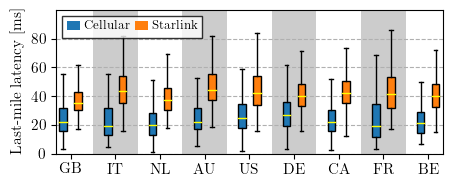

In [11]:

rcParams["font.size"] = 11
def adjust_box(plot):
    for i in range(2):
        plt.setp(plot['boxes'][i], facecolor=cols[i], linewidth=1)
        plt.setp(plot['medians'][i], color='yellow')

countries = ['GB', 'IT', 'NL', 'AU', 'US', 'DE', 'CA', 'FR', 'BE']

for country in countries:
    sc_other_abs[country] =[x for x in sc_other_abs[country] if x < 100]
fig, ax = plt.subplots(figsize=(4.66, 2))

pos1 = np.arange(0, 3 * len(countries), 3)
pos2 = np.arange(1, 3 * len(countries) + 1, 3)
ax.boxplot([sc_other_abs[country] for country in countries], positions=pos1, patch_artist=True,
           showfliers=False, boxprops=dict(facecolor=cols[0], lw=1), medianprops=dict(color="yellow"))
ax.boxplot([ripe_abs[country] for country in countries], positions=pos2, patch_artist=True,
           showfliers=False, boxprops=dict(facecolor=cols[1], lw=1), medianprops=dict(color="yellow"))
xspan = 3
[ax.axvspan(i * xspan - 1, i * xspan - 1 + xspan, facecolor="k", alpha=0.2)
    for i in range(len(countries))
    if i % 2 == 1]

ax.set_xticks(np.arange(0.5, 3 * len(countries), 3))
ax.set_xticklabels(countries)
ax.set_ylabel("Last-mile latency [ms]")
ax.set_yticks(np.arange(0, 90, 20))
ax.set_ylim(-5,90)
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

handles = [Patch(facecolor=col) for col in cols[:4]]
labels = ["Cellular", "Starlink"]

ax.legend(handles, labels, loc="upper left", fontsize="small", edgecolor="k", handlelength=1, 
          labelspacing=0.06, columnspacing=0.5, handletextpad=0.3, fancybox=False, ncol=4)
plt.grid(True, axis="y", linestyle="--")
plt.ylim(0,100)
fig.tight_layout()

plt.savefig("Figs/Last-mile_abs_SCcell_vs_Atlas_new.pdf", bbox_inches = "tight", pad_inches = 0)
plt.savefig("Figs/Last-mile_abs_SCcell_vs_Atlas_new.svg", bbox_inches = "tight", pad_inches = 0)
plt.show()

## Prepare Starlink Dishy to GS RTT vs Distance data

In [12]:
outlier_map = {}


all_prb_details_file = open(f"{base_folder}/ripe_prb_details/all_final_prb_details_ripe.json", "r")
all_prb_details_json = json.load(all_prb_details_file)


dist_to_rtt = {}


pop_details_file_old = open(f"{base_folder}/starlink_pop_details/pop_coordinates_old.json", "r")
pop_details_file_new = open(f"{base_folder}/starlink_pop_details/pop_coordinates_new.json", "r")
pop_details_json_old = json.load(pop_details_file_old)
pop_details_json_new = json.load(pop_details_file_new)

for tracert in first_hop_filtered_json_list_old_msm:
    prb_id = str(tracert['prb_id'])
    # 61113 prb - Filtering it out as it is serviced by probes above the 53° inclination angle or using ISLs, and outlier probe
    # 28 prb is faulty - RTT to local user router/network is often between 40-50ms
    if prb_id in ["28", "61113",]:
        continue
    prb_coords = (all_prb_details_json[prb_id]['latitude'], all_prb_details_json[prb_id]['longitude'])
    pop_ip_set = set()
    pop_coords = None
    for idx in range(3):
        try:
            pop_ip = tracert['pop_hop_ip'][idx]
            pop_ip_set.add(pop_ip)
            pop_coords = (pop_details_json_old[pop_ip]['Latitude'],pop_details_json_old[pop_ip]['Longitude'])
        except:
            pop_ip_set.clear()
            continue
    if len(pop_ip_set) == 1 and len(tracert['pop_rtts']) and len(tracert['gs_rtts']):
        pop_median_rtt = statistics.median(tracert['pop_rtts'])
        gs_median_rtt = statistics.median(tracert['gs_rtts'])
        if round(pop_median_rtt - gs_median_rtt) >=0  and round(pop_median_rtt - gs_median_rtt) <=1 :

            dist = hs.haversine(prb_coords, pop_coords)
            rounded_dist = round(dist)
            if rounded_dist not in dist_to_rtt:
                dist_to_rtt[rounded_dist] = []
            dist_to_rtt[rounded_dist] += tracert['gs_rtts']          
        

for tracert in first_hop_filtered_json_list_new_msm:
    prb_id = str(tracert['prb_id'])
    # 61113 prb - Filtering it out as it is serviced by probes above the 53° inclination angle or using ISLs, and outlier probe
    # 26696 prb is faulty - RTT to local user router is often between 40-50ms
    # 28 prb is faulty - RTT to local user router/network is often between 40-50ms
    # 60797 prb is in RU - uses ISL
    if prb_id in ["28", "61113", "60797", "26696"]:
        continue
    prb_coords = (all_prb_details_json[prb_id]['latitude'], all_prb_details_json[prb_id]['longitude'])
    pop_ip_set = set()
    pop_coords = None
    for idx in range(3):
        try:
            pop_ip = tracert['pop_hop_ip'][idx]
            pop_ip_set.add(pop_ip)
            pop_coords = (pop_details_json_new[pop_ip]['Latitude'],pop_details_json_new[pop_ip]['Longitude'])
            if pop_details_json_new[pop_ip]['City'] in ["Australia", "New Zealand"]:
                pop_ip_set.clear()
                continue
        except:
            pop_ip_set.clear()
            continue

    if len(pop_ip_set) == 1 and len(tracert['pop_rtts']) and len(tracert['gs_rtts']):
        pop_median_rtt = statistics.median(tracert['pop_rtts'])
        gs_median_rtt = statistics.median(tracert['gs_rtts'])
        if round(pop_median_rtt - gs_median_rtt) >=0  and round(pop_median_rtt - gs_median_rtt) <=1 :
            dist = hs.haversine(prb_coords, pop_coords)
            rounded_dist = round(dist)

            if rounded_dist not in dist_to_rtt:
                dist_to_rtt[rounded_dist] = []

            dist_to_rtt[rounded_dist] += tracert['gs_rtts']
          
        


## Plotting Starlink Dishy to GS RTT vs Distance data

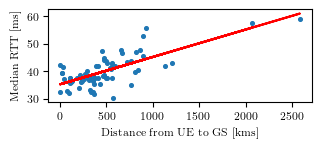

In [13]:
distances = []
median_rtts = []

rcParams["font.size"] = 8
fig, ax = plt.subplots(figsize=(3.4, 1.2))

for dist, rtt_list in dist_to_rtt.items():
    if len(rtt_list) >= 1000:
        median_rtt = statistics.median(rtt_list)
        if dist > 0:
            distances.append(dist)
            median_rtts.append(median_rtt)

x=np.array(distances)
y=np.array(median_rtts)
ax.scatter(x,y, s= 7)
ax.yaxis.set_ticks(np.arange(10,100,10))

slope, intercept, r_value, p_value, std_err = stats.linregress(distances, median_rtts)
dist_rtt_bestfitline = [slope*x + intercept for x in distances]
plt.xlabel("Distance from UE to GS [kms]")
plt.ylabel("Median RTT [ms]")
plt.plot(x, slope*x + intercept, color="r")
plt.savefig("Figs/Last_mile_vs_POPdistance.pdf", bbox_inches = "tight", pad_inches = 0)
plt.savefig("Figs/Last_mile_vs_POPdistance.svg", bbox_inches = "tight", pad_inches = 0)

## Plotting Starlink last-mile RTT performance - a latitudinal comparison 

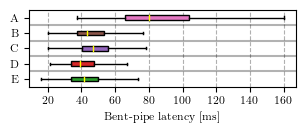

In [14]:
ripe_abs_prb_new = {}
ripe_var_prb_new = {}

def adjust_box(plot,idx):
    for i in range(1):
        plt.setp(plot['boxes'][i], facecolor=cols[idx+1], linewidth=1)
        plt.setp(plot['medians'][i], color='yellow')

for tracert in first_hop_filtered_json_list:
    prb_id = tracert['prb_id']
    if prb_id not in ripe_abs_prb_new:
        ripe_abs_prb_new[prb_id] = []
        ripe_var_prb_new[prb_id] = []
    if len(tracert['gs_rtts']):
        ripe_abs_prb_new[prb_id] += tracert['gs_rtts']
        ripe_var_prb_new[prb_id].append(stats.variation(tracert['gs_rtts']))


fig, ax = plt.subplots(figsize=(3.45, 1.0))
i = 0
probes = []
for prb_id in [61113, 11585, 55492, 17979, 1002750,][::-1]:
    width = 0.3
    bp = ax.boxplot(ripe_abs_prb_new[prb_id], positions=[i,], showfliers=False,  patch_artist=True, widths=width, vert=False)
    i += 1
    adjust_box(bp,i)
    probes.append(prb_id)
    letters = ["A", "B", "C", "D", "E"][::-1]
plt.grid(True, axis="x", linestyle="--")
ax.set_yticks(np.arange(0, len(probes), 1))
ax.set_yticklabels(letters)
ax.set_xticks(np.arange(20, 180, 20))
ax.set_xticklabels([20,40,60,80,100,120,140,160])
ax.set_xlabel("Bent-pipe latency [ms]")
# ax.set_ylabel("Probes")
[ax.axhline(x+.5,color='k', alpha=0.3) for x in ax.get_yticks()]
plt.savefig("Figs/ripe_last_mile_probe_lat_location_New.pdf", bbox_inches = "tight", pad_inches = 0)
plt.savefig("Figs/ripe_last_mile_probe_lat_location_New.svg", bbox_inches = "tight", pad_inches = 0)
plt.show()

## Plotting RIPE Atlas Global vantage points and Mlab measurement density per country

/var/folders/6h/lb4zy10n69qgx1bpl1s10qp00000gn/T/ipykernel_2042/2139680497.py:16: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')


/var/folders/6h/lb4zy10n69qgx1bpl1s10qp00000gn/T/ipykernel_2042/2139680497.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


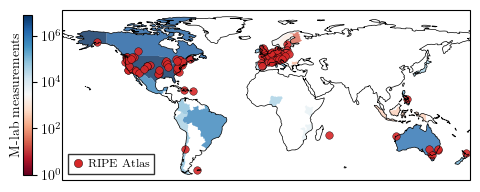

In [16]:
mlab_probes_dict = {}
mlab_df = pd.read_csv(f'{base_folder}/mlab_agg/mlab_starlink_country_agg.csv')

for _, row in mlab_df.iterrows():
    if row['CountryName'] not in mlab_probes_dict:
        mlab_probes_dict[row['CountryName']] = 0
    mlab_probes_dict[row['CountryName']] += row['count_measurements']

rcParams["font.size"] = 10
rcParams["font.family"] = "CMU Sans Serif"
gs_df = pd.read_csv(f'{base_folder}/ripe_prb_details/all_final_prb_details_new.csv')
controlled_df = pd.read_csv(f'{base_folder}/ripe_prb_details/controlled_prb_details.csv')
gdf = geopandas.GeoDataFrame(gs_df, geometry=geopandas.points_from_xy(gs_df.longitude, gs_df.latitude))
gdf_controlled = geopandas.GeoDataFrame(controlled_df, geometry=geopandas.points_from_xy(controlled_df.longitude, controlled_df.latitude))

world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world = world[(world.name!="Antarctica")]
print(world.keys())

countries_plotted = set()
mlab_density = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name in mlab_probes_dict:
        mlab_density.append(mlab_probes_dict[name])
        countries_plotted.add(name)
    elif code == "-99":
        mlab_density.append(float("NaN"))
    else:
        mlab_density.append(float("nan"))



world["mlab"] = mlab_density
fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = pltColors.ListedColormap(cols[:-4])
total_bins = [2**x for x in range(24)]
handles = []
ripe_handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=cols[3], markeredgecolor="black", markeredgewidth=0.3)
           for i in range(1)]
labels = ["RIPE Atlas"]
handles = ripe_handles
ax.coastlines(linewidth=0.5)
world.plot(column="mlab", cmap='RdBu', scheme='UserDefined', classification_kwds=dict(bins=total_bins),
           ax=ax, alpha=0.8,)
gdf.plot(marker="o", facecolor=cols[3], edgecolor="black", ax=ax, markersize=30, linewidth=0.3, alpha=0.9)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")


# Create colorbar as a legend
sm = plt.cm.ScalarMappable(norm=pltColors.LogNorm(vmin=1, vmax=8388608), cmap='RdBu') 
# Empty array for the data range
sm._A = []
# Add the colorbar to the figure
cbaxes = fig.add_axes([-0.022, 0.10, 0.02, 0.8])
cbar = fig.colorbar(sm, cax=cbaxes)
cbar.set_label("M-lab measurements", labelpad = -37)
# cbar.ax.get_yaxis.set_ticks([])
fig.tight_layout()
plt.savefig("Figs/global_vantage_points.pdf", bbox_inches = "tight", pad_inches = 0.1)
plt.savefig("Figs/global_vantage_points.svg", bbox_inches = "tight", pad_inches = 0.1)
plt.show()

## Plotting per-country GS to POP RTT performance

/var/folders/6h/lb4zy10n69qgx1bpl1s10qp00000gn/T/ipykernel_2042/4006769974.py:34: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))


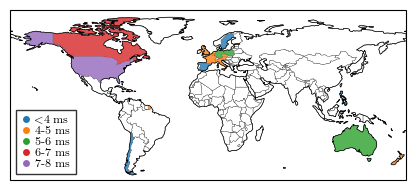

In [17]:
country_rtt_diff_map = {}
code_country_json = json.load(open(f"{base_folder}/common/code_to_country_name.json","r"))

for tracert in first_hop_filtered_json_list:
    country = tracert['country_code']
    
    gs_ips_rtt = []
    pop_ips_rtt = []

    gs_ips_rtt += tracert['gs_rtts']

    pop_ips_rtt += tracert['pop_rtts']

    if len(gs_ips_rtt) and len(pop_ips_rtt):
        
        median_gs_rtt = statistics.median(gs_ips_rtt)
        median_pop_rtt= statistics.median(pop_ips_rtt)
        if median_pop_rtt >= median_gs_rtt:
            if country not in country_rtt_diff_map:
                country_rtt_diff_map[country] = []
            country_rtt_diff_map[country].append(median_pop_rtt - median_gs_rtt)
        gs_ips_rtt.clear()
        pop_ips_rtt.clear()
            


country_median_rtt_diff = {}

for code, rtt_list in country_rtt_diff_map.items():
    country_name = code_country_json[code]
    country_median_rtt_diff[country_name] = statistics.median(rtt_list)

cols = plt.get_cmap("tab10").colors
world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
world = world[(world.name!="Antarctica")]


rtt_diff_latency = []
for name, code in zip(world["name"], world["iso_a3"]):
        
    if name in country_median_rtt_diff:
        rtt_diff_latency.append(country_median_rtt_diff[name])

    elif code == "-99":
        rtt_diff_latency.append(float("nan"))
    else:
        rtt_diff_latency.append(float("nan"))



world["rtt_diff"] = rtt_diff_latency
fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = pltColors.ListedColormap(cols[:-5])

labels = ["$<$4 ms", "4-5 ms", "5-6 ms", "6-7 ms", "7-8 ms"]
ax.coastlines(linewidth=0.5)
world.plot(facecolor ="white", edgecolor="black", ax=ax, linewidth=0.2)
world.plot(column="rtt_diff", cmap=cmap, scheme='UserDefined', classification_kwds=dict(bins=[4,5,6,7,8]),
           ax=ax, alpha=0.8,)

ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]

ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

plt.savefig("Figs/ripe_gs_to_pop_latency.pdf", bbox_inches = "tight", pad_inches = 0.1)
plt.savefig("Figs/ripe_gs_to_pop_latency.svg", bbox_inches = "tight", pad_inches = 0.1)
fig.tight_layout()
plt.show()

## Plotting Starlink ISL comparison

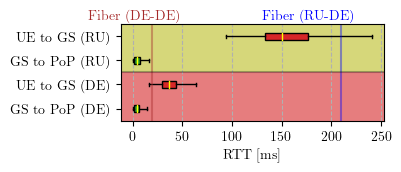

In [18]:
tracert_breakup_60797 = {
    "UE to GS" :[],
    "GS to PoP" : [],
    "PoP to Dest.": [],
}

for tracert in first_hop_filtered_json_list:
    prb_id = tracert['prb_id']
    dst_addr = tracert['dst_addr']

    if prb_id == 60797 and dst_addr == "13.245.232.79":
        if len(tracert["gs_rtts"]) and len(tracert["pop_rtts"]) and len(tracert["total_rtts"]):
            tracert_breakup_60797["UE to GS"] += tracert['gs_rtts']
            median_gs_rtt = statistics.median(tracert["gs_rtts"])
            median_pop_rtt = statistics.median(tracert["pop_rtts"])
            if median_pop_rtt > median_gs_rtt:
                tracert_breakup_60797["GS to PoP"].append(median_pop_rtt - median_gs_rtt)
            median_total_rtt = statistics.median(tracert["total_rtts"])
            if median_total_rtt > median_pop_rtt:
                tracert_breakup_60797["PoP to Dest."].append(median_total_rtt - median_pop_rtt)

tracert_breakup_EU = {
    "UE to GS" :[],
    "GS to PoP" : [],
    "PoP to Dest.": [],
}

for tracert in first_hop_filtered_json_list:
    prb_id = tracert['prb_id']
    dst_addr = tracert['dst_addr']

    if prb_id == 60323 and dst_addr == "13.245.232.79":
        if len(tracert["gs_rtts"]) and len(tracert["gw_rtts"]) and len(tracert["pop_rtts"]) and len(tracert["total_rtts"]):
            tracert_breakup_EU["UE to GS"] += tracert['gs_rtts']
            median_gs_rtt = statistics.median(tracert["gs_rtts"])
            median_pop_rtt = statistics.median(tracert["pop_rtts"])
            if median_pop_rtt > median_gs_rtt:
                tracert_breakup_EU["GS to PoP"].append(median_pop_rtt - median_gs_rtt)
            median_total_rtt = statistics.median(tracert["total_rtts"])
            if median_total_rtt > median_pop_rtt:
                tracert_breakup_EU["PoP to Dest."].append(median_total_rtt - median_pop_rtt)

terrestrial_tracert_RU_json = json.load(open(f"{base_folder}/isl_msms/AWS_ec2_traceroute_id_61502773_RU.json", "r"))
terrestrial_RTT_to_FRA = []
dst_server_ip = "3.70.191.175"
for tracert in terrestrial_tracert_RU_json:
    if len(tracert['result']):
        last_hop = tracert['result'][-1]
        for result in last_hop['result']:
            if 'from' in result:
                if result['from'] == dst_server_ip:
                    terrestrial_RTT_to_FRA.append(result['rtt'])

terrestrial_tracert_DE_json = json.load(open(f"{base_folder}/isl_msms/AWS_ec2_traceroute_id_61653870_DE.json", "r"))
terrestrial_RTT_within_DE = []
dst_server_ip = "3.70.191.175"
for tracert in terrestrial_tracert_DE_json:
    if len(tracert['result']):
        last_hop = tracert['result'][-1]
        for result in last_hop['result']:
            if result['from'] == dst_server_ip:
                terrestrial_RTT_within_DE.append(result['rtt'])


portions = []
def adjust_box(plot,idx):
    for i in range(1):
        plt.setp(plot['boxes'][i], facecolor=cols[idx+1], linewidth=1)
        plt.setp(plot['medians'][i], color='yellow')

fig, ax = plt.subplots(figsize=(3.4, 1.25))
i = 0
pos_idx = 0
for msm in list(tracert_breakup_EU.keys())[::-1]:
    if msm == "PoP to Dest.":
        continue
    width = 0.3
    bp = ax.boxplot(tracert_breakup_EU[msm], positions=[pos_idx,], showfliers=False,  patch_artist=True, widths=width, vert=False)
    pos_idx += 1
    i += 1
    adjust_box(bp,i)
    portions.append(msm + " (DE)")
i = 0
for msm in list(tracert_breakup_60797.keys())[::-1]:
    if msm == "PoP to Dest.":
        continue
    width = 0.3
    bp = ax.boxplot(tracert_breakup_60797[msm], positions=[pos_idx,], showfliers=False,  patch_artist=True, widths=width, vert=False)
    pos_idx += 1
    i += 1
    adjust_box(bp,i)
    portions.append(msm + " (RU)")


ax.axvline(statistics.median(terrestrial_RTT_to_FRA), color="blue", alpha=0.4)
ax.axvline(statistics.median(terrestrial_RTT_within_DE), color="brown", alpha=0.4)
plt.grid(True, axis="x", linestyle="--")
ax.set_yticks(np.arange(0, len(portions), 1))
ax.set_yticklabels(portions)
ax.set_xlabel("RTT [ms]")
ax.axhspan(1.5, 3.5, facecolor=cols[8], alpha=0.6)
ax.axhspan(-0.5, 1.5, facecolor=cols[3], alpha=0.6)
ax.axhline(1.5, color='k', alpha =0.3)
ax.text(130, 3.7, 'Fiber (RU-DE)', style='italic', color = "blue")
ax.text(-45, 3.7, 'Fiber (DE-DE)', style='italic', color = "brown")
plt.savefig("Figs/isl_vs_non_isl_vs_terrestrial.pdf", bbox_inches = "tight", pad_inches = 0)
plt.savefig("Figs/isl_vs_non_isl_vs_terrestrial.svg", bbox_inches = "tight", pad_inches = 0)
plt.show()
